El objetivo de esta notebook es encontrar los colores más representativos de los commodities en cuestión. 
Este trabajo está destinado a ser utilizado en Mobile, ya que los colores encontrados serán utilizados en el patrón de corrección.

Lo ideal es utilizar un patrón diferente para cada commodity, pero dado que al momento de la fecha solo dos commodities son utilizadas por Mobile, se realizará un análisis en conjunto.

Antes de comenzar con dicho análisis se deben obtener crops de cada tipo (label) de cada commodity.

In [1]:
import cv2 as cv
import numpy as np
from PIL import Image, ImageChops, ImageFilter
import json
import os
from matplotlib.pyplot import imshow

from zoomModels.utils import mcoco_to_zcoco
from zoomModels.models import Zoomcoco
from pycocotools.mask import frPyObjects, decode

from pattern_generator import PatternGenerator

Para obtener los crops individuales sin fondo, se deben conseguir los scans y luego las máscaras. Éstas últimas son relativas, es decir, funcionan para cada crop individual. La forma de conocer en qué ubicación se debe aplicar es mediante bbox (Bounding Box). Para ello, se deberán encontrar los scans, las máscaras y las bbox.

Las funciones utilizadas son las siguientes:

- build_rle_dict() es define un diccionario que precisa pycocotools.

- get_masks() obtiene las máscaras a partir del zoomcoco obtenido del json. En s3 el json se encuentra bajo el nombre de 'filename_json'.

- generate_crops() genera los crops individuales a partir de los scans y las máscaras. A cada máscara se le aplica erosión para eliminar parte de los bordes azules, resultantes del crop. Aunque se eliminan los bordes de los crops en el proceso, los mismos no contienen información representativa al no ser correctamente iluminados por el escáner.

In [3]:
def build_rle_dict(rle_object):
    # some ugly piece of shit function
    return {'counts': rle_object.counts, 'size': rle_object.size}


def get_masks(zoomcoco):
    
    masks = []
    bbox = []
    
    for grain in zoomcoco.grains:
        for crop in grain.crops_list:
            
            # pycocotools needs a dict, not an object...
            rle = build_rle_dict(crop.mask_rle)
            rle = frPyObjects(rle, rle['size'][0], rle['size'][1])
            mask = Image.fromarray(np.uint8(255 * decode(rle)))
            masks.append(mask)
            bbox.append(crop.bbox)

    return masks, bbox


def generate_crops(scan, zoomcoco):
    
    masks, bbox = get_masks(zoomcoco)

    processed_crops = []   
    
    for msk, bb in zip(masks, bbox):
        crop = scan.crop(box=(bb[0], bb[1], bb[2] + bb[0], bb[3] + bb[1]))
        msk = msk.filter(ImageFilter.MinFilter(3))
        msk = msk.filter(ImageFilter.MinFilter(3))
        processed_crop = ImageChops.multiply(crop.convert('RGB'), msk.convert('RGB'))
        processed_crops.append(np.array(processed_crop))
        
    return processed_crops

Primero se debe encontrar el path en el que se encuentran los datos (scans, jsons). Estos fueron descargados de s3 mediante un script localizado en el repositorio 'inutils'.

Se recorren los archivos y directorios, y se filtran los archivos de imagen y sus respectivos json.
Los json contienen una estructura llamada minicoco. La misma está desactualizada. Ahora se utiliza zoomcoco. Se utiliza mcoco_to_zcoco() para hacer la conversión de una a la otra.

In [4]:
path = os.path.abspath(os.getcwd()) + '/job'

crops = []

for root, dirs, files in os.walk(path):
    
    jsons = []
    scans = []

    for file in files:
        
        filename, file_extension = os.path.splitext(file)
        path_to_file = os.path.join(root, file)
        
        if file_extension == '.json':
            jsons.append(path_to_file)
            
        if file_extension == '.png':
            scans.append(path_to_file)
            
    for path_to_scan, path_to_json in zip(scans, jsons):

        # Read json file
        with open(path_to_json) as json_file:
            minicoco = json.load(json_file)
            zoomcoco = mcoco_to_zcoco(minicoco)
            
        # Read image file
        image = Image.open(path_to_scan)
        
        # Process
        crops.append(generate_crops(image, zoomcoco))

Los crops ahora pueden ser vistos fácilmente. El primer subíndice es para desplazarse por scans, mientras que el segundo es el crop.

Ejemplo:

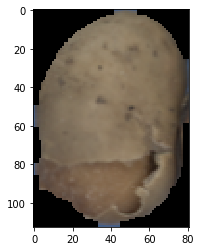

In [5]:
%matplotlib inline
imshow(crops[1][2])

Ahora se precisa de concatenar todos los datos. Más específicamente, concatenar cada píxel, es decir, cada color. Para ello se deben eliminar las estructuras subyacentes dentro de crops. Finalmente se debe obtener una estructura de tamaño (shape) Mx3, donde M resulta la cantidad de pixeles de interés y 3 la cantidad de canales (R,G,B).

In [6]:
data = []

for scan in crops:
    for grain in scan:
        colors = grain.reshape(grain.shape[0]*grain.shape[1], grain.shape[2])
        data.append(colors)

data = np.vstack(data)

print(data.shape)

(195560560, 3)


Como se pudo observar anteriormente, gran parte de la imagen queda en negro. Estos pixeles resultan irrelevantes para el análisis en cuestión. Adicionalmente, el color negro se encontrará en el patrón de todas formas. Por lo tanto, no serán considerados. Numpy no proveé funciones para filtrar arreglos de arreglos con facilidad, y la conversión a 'list' consume muchos recursos, provocando el detenimiento del kernel. Se resolvió el problema de la siguiente forma:

In [19]:
filtered_data = data[data[:,0] + data[:,1] + data[:,2] != 0]
print(filtered_data.shape)

(128176005, 3)


Finalmente, se estiman los 48 centros de color (48 son el máximo de colores utilizados en el patrón) mediante k-means.

In [21]:
# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 48
ret, label, center = cv.kmeans(filtered_data.astype(np.float32), K, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)

center = np.uint8(center)

A continuación se pueden observar los resultados:

In [23]:
print(center)

[[181 173 157]
 [ 73 123 145]
 [188 167 137]
 [ 41  40  42]
 [173 161 142]
 [164 155 141]
 [154 125  76]
 [168 105 146]
 [106  79  66]
 [190 156 113]
 [191 142  72]
 [122  88 118]
 [143 142 135]
 [127 105  69]
 [ 78 231 143]
 [171 182 178]
 [135  90 145]
 [179 148 115]
 [ 66  34 145]
 [167 122 147]
 [154 152 144]
 [185 191 189]
 [143  99 136]
 [190 190 181]
 [ 27  28  31]
 [126 103  92]
 [165 129 102]
 [157 141 118]
 [152 109 148]
 [215 178 122]
 [133 115  89]
 [222 198 162]
 [163 230  40]
 [154 111 125]
 [190 188 164]
 [128 129 114]
 [179 133  97]
 [101 114 127]
 [ 69  60  56]
 [ 87 127 174]
 [ 68 194 120]
 [126 119 151]
 [142 123  94]
 [ 84  96  92]
 [116  97 137]
 [104 117 102]
 [ 72 100 137]
 [144 127  98]]


Se guardan los datos, para evitar correr el programa nuevamente.

In [58]:
np.savetxt("V3a/center.csv", center, fmt='%d', delimiter=',', newline='\n', header='', footer='', comments='# ', encoding=None)


NameError: name 'center' is not defined

Ahora se lee el archivo y se muestra el patrón de color obtenido:

In [2]:
centers = np.loadtxt("V3a/center.csv", delimiter =',')

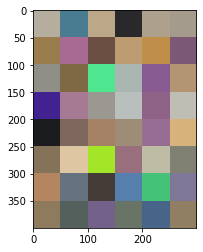

In [4]:
generator = PatternGenerator(centers, None, rows=8, cols=6, color_size=50)
pattern = generator.run('get')
imshow(pattern)